## IMPORT LIBRARES AND PACKAGES

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2

from PIL import Image
from scipy import stats

from keras.utils import to_categorical

2023-11-26 22:35:23.007281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 22:35:23.053104: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 22:35:23.054293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 22:35:23.769286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## [1] DATA PREPARATION

Setup data directory

In [2]:
IMAGE_DIRECTORY = "./data-1/cohn-kanade-images/"
DATA_LABEL_DIRECTORY = "./data-1/data_labels.csv"

#### Load Label Dataset

In [3]:
df = pd.read_csv(DATA_LABEL_DIRECTORY)

Explore head

In [4]:
df.head(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,S005,1,11,./cohn-kanade-images/S005/001/S005_001_0000001...,S005_001_00000011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,S010,1,14,./cohn-kanade-images/S010/001/S010_001_0000001...,S010_001_00000014,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
2,S010,2,14,./cohn-kanade-images/S010/002/S010_002_0000001...,S010_002_00000014,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
3,S010,3,18,./cohn-kanade-images/S010/003/S010_003_0000001...,S010_003_00000018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,S010,4,19,./cohn-kanade-images/S010/004/S010_004_0000001...,S010_004_00000019,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,negative


Explore Tail

In [5]:
df.tail(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
555,S506,4,38,./cohn-kanade-images/S506/004/S506_004_0000003...,S506_004_00000038,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
556,S506,6,42,./cohn-kanade-images/S506/006/S506_006_0000004...,S506_006_00000042,1,1,1,0,0,...,0,0,0,0,0,1,0,0,1,negative
557,S895,2,7,./cohn-kanade-images/S895/002/S895_002_0000000...,S895_002_00000007,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,negative
558,S999,1,18,./cohn-kanade-images/S999/001/S999_001_0000001...,S999_001_00000018,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,negative
559,S999,3,55,./cohn-kanade-images/S999/003/S999_003_0000005...,S999_003_00000055,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,negative


Convert Emotion Label To Numeric

In [6]:
target_mapping = {'negative': 0, 'positive': 1, 'surprise': 2}
df['high_level_emotion_num'] = df['high_level_emotion'].map(target_mapping)

#### 1.1 DATA INTEGRITY CHECKING

Check Duplicate

In [7]:
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 0


Check Nan Value

In [8]:
print('Number of Nan value rows:\n', df.isnull().sum())

Number of Nan value rows:
 subject                   0
sequence                  0
image_index               0
filepath                  0
file_prefix               0
AU17                      0
AU1                       0
AU2                       0
AU25                      0
AU27                      0
AU4                       0
AU7                       0
AU23                      0
AU24                      0
AU6                       0
AU12                      0
AU15                      0
AU14                      0
AU11                      0
AU26                      0
high_level_emotion        0
high_level_emotion_num    0
dtype: int64


Check Data Overall 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subject                 560 non-null    object
 1   sequence                560 non-null    int64 
 2   image_index             560 non-null    int64 
 3   filepath                560 non-null    object
 4   file_prefix             560 non-null    object
 5   AU17                    560 non-null    int64 
 6   AU1                     560 non-null    int64 
 7   AU2                     560 non-null    int64 
 8   AU25                    560 non-null    int64 
 9   AU27                    560 non-null    int64 
 10  AU4                     560 non-null    int64 
 11  AU7                     560 non-null    int64 
 12  AU23                    560 non-null    int64 
 13  AU24                    560 non-null    int64 
 14  AU6                     560 non-null    int64 
 15  AU12  

## [2] EXPLORATORY DATA ANALYSIS

2.1 Check Label Count

/tmp/ipykernel_64469/2055809110.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)


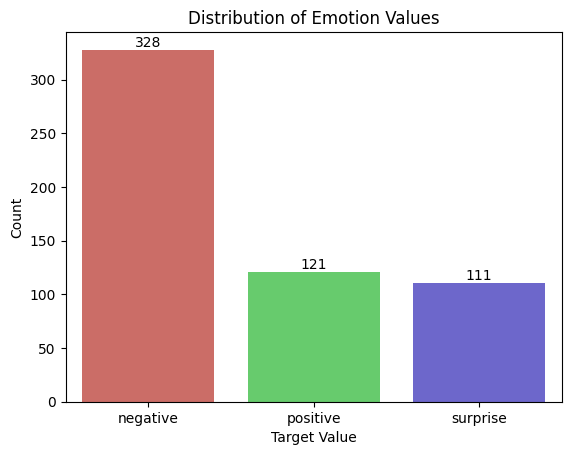

In [10]:
# Get the counts of each target value
target_value_counts = df['high_level_emotion'].value_counts()

# Create a bar plot
ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)

# Show the number of observations inside each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of Emotion Values')
plt.show()

**Observation**

It seems there are unbalanced count of negative comparing to other label

2.2 Visual Inspectation

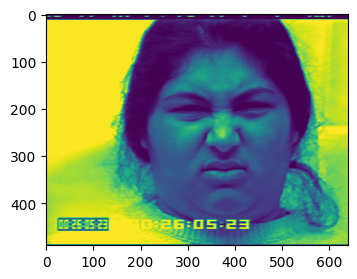

In [11]:
# For simplicity, let's just take the first subject and its first sequence
subject_sequence = df[(df['subject'] == 'S005') & (df['sequence'] == 1)]
sequence_files = subject_sequence['filepath'].tolist()

# Ensure that axes is always iterable
fig, axes = plt.subplots(1, len(sequence_files), figsize=(15, 3))
if len(sequence_files) == 1:
    axes = [axes]  # Make it a list so it's iterable

for ax, file in zip(axes, sequence_files):
    # Correct the file path by stripping the redundant part
    corrected_file_path = file.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('on')
    except IOError:
        print(f"Error opening image: {img_path}")

plt.show()

In [12]:
# Define an empty list to hold image sizes
image_sizes = []

# Define lists to hold mean and standard deviation of pixel values
mean_pixel_values = []
std_pixel_values = []

# Define a list to hold paths of corrupt images
corrupt_images = []

img_path_list = []
# Loop through the file paths in DataFrame
for file_path in df['filepath']:
    corrected_file_path = file_path.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    img_path_list.append(img_path)
    try:
        # Open the image and convert it to RGB (in case some are grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Check if the image is read correctly
        if img is not None:
            # Append the image size
            image_sizes.append(img.shape)
            
            # Calculate and store the mean and standard deviation of pixel values
            mean_pixel_values.append(np.mean(img))
            std_pixel_values.append(np.std(img))
        else:
            # If img is None, the image is corrupt
            corrupt_images.append(img_path)
            
    except Exception as e:
        # If an exception is raised, the image is likely corrupt
        corrupt_images.append(img_path)

In [13]:
# Now let's analyze the image sizes
image_sizes = np.array(image_sizes)
unique_sizes = np.unique(image_sizes, axis=0)

# We can print out or plot the unique sizes to decide on a common size
print(f"Unique image sizes: {unique_sizes}")

Unique image sizes: [[480 640   3]
 [480 720   3]
 [490 640   3]]


In [14]:
# Calculate the overall mean and standard deviation for the pixel values
overall_mean = np.mean(mean_pixel_values)
overall_std = np.std(std_pixel_values)

print(f"Overall mean pixel value: {overall_mean}")
print(f"Overall standard deviation of pixel values: {overall_std}")

# Print out corrupt images, if any
if corrupt_images:
    print("Found corrupt images:")
    for corrupt_img in corrupt_images:
        print(corrupt_img)
else:
    print("No corrupt images found.")

Overall mean pixel value: 99.93890188972647
Overall standard deviation of pixel values: 9.063075756547514
No corrupt images found.


In [15]:
# Background Consistency Check
background_modes = []

for img_path in img_path_list:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale simplifies the analysis
    border_pixels = np.concatenate([img[0, :], img[-1, :], img[:, 0], img[:, -1]])  # Extract border pixels
    mode = stats.mode(border_pixels)  # Find the mode of the border pixels
    background_modes.append(mode)

/tmp/ipykernel_64469/3067096416.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(border_pixels)  # Find the mode of the border pixels


Mean mode value: 11.378571428571428
Standard deviation of mode values: 47.69470887951871


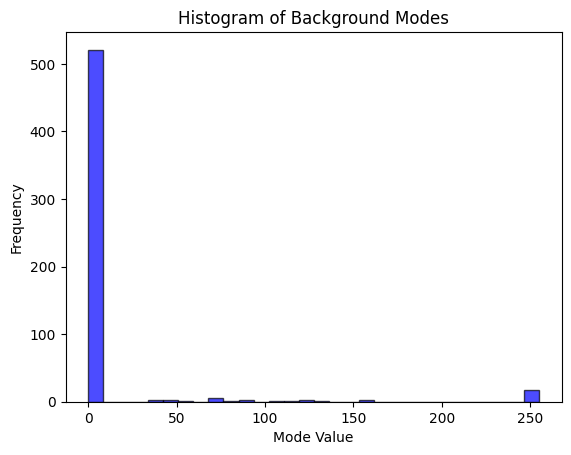

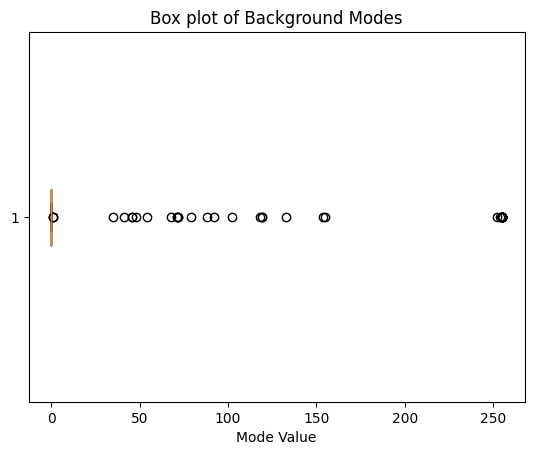

In [16]:

# Extract the mode values and counts
mode_values = [mode.mode[0] for mode in background_modes]
mode_counts = [mode.count[0] for mode in background_modes]

# Calculate basic statistics
mean_mode = np.mean(mode_values)
std_dev_mode = np.std(mode_values)

print(f"Mean mode value: {mean_mode}")
print(f"Standard deviation of mode values: {std_dev_mode}")

# Visualize the distribution of mode values
plt.hist(mode_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Background Modes')
plt.xlabel('Mode Value')
plt.ylabel('Frequency')
plt.show()

# Box plot for detecting outliers
plt.boxplot(mode_values, vert=False)
plt.title('Box plot of Background Modes')
plt.xlabel('Mode Value')
plt.show()

## [3] SETUP AND EXTRACT ESSENTIAL DATA 

3.1 Build Dataloader

In [17]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import dlib

import numpy as np

class CustomDataLoader(Sequence):
    def __init__(self, image_filepaths, labels, batch_size, image_size, shuffle=True, augment=False):
        """
        Custom data loader for CNN.
    
        :param image_filepaths: List of file paths for the images.
        :param labels: Dictionary containing AU labels and emotion labels.
        :param batch_size: Batch size for the data loader.
        :param image_size: Tuple representing the size of the image.
        :param shuffle: Boolean, whether to shuffle the data after each epoch.
        :param augment: Boolean, whether to apply data augmentation.
        """
        self.image_filepaths = image_filepaths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        # Load the pre-trained facial landmark predictor
        self.predictor_path = "./shape_predictor_68_face_landmarks.dat"  
        self.face_detector = dlib.get_frontal_face_detector()
        self.landmark_predictor = dlib.shape_predictor(self.predictor_path)
        # List of AU codes 
        self.au_codes = [17, 1, 2, 25, 27, 4, 7, 23, 24, 6, 12, 15, 14, 11, 26]
        

        self.on_epoch_end()

        # Data augmentation configuration
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return int(np.ceil(len(self.image_filepaths) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        # Generate indexes of the batch
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch.
        """
        self.indices = np.arange(len(self.image_filepaths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def place_on_black_background(self, cropped_face, bg_size=(48, 48)):
        # Create a black background
        background = np.zeros((bg_size[0], bg_size[1]), dtype=np.uint8)

        # Calculate the centering position
        x_offset = (bg_size[1] - cropped_face.shape[1]) // 2
        y_offset = (bg_size[0] - cropped_face.shape[0]) // 2

        # Place the cropped face in the center of the black background
        background[y_offset:y_offset+cropped_face.shape[0], x_offset:x_offset+cropped_face.shape[1]] = cropped_face
        return background

    def __data_generation(self, indexes):
        """
        Generates data containing batch_size samples.
        """
        # Initialization
        X = np.empty((len(indexes), *self.image_size, 1))
        # y_facs = np.empty((len(indexes), len(self.labels['facs_output'][0])), dtype=int)
        # Dictionary for AU outputs
        y_au_outputs = {f'AU{au_code}_output': np.empty((len(indexes), 1), dtype=int) for au_code in self.au_codes}
        y_emotion = np.empty((len(indexes), len(self.labels['emotion_output'][0])), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):
            # Load and preprocess the image
            img = load_img(self.image_filepaths[idx], target_size=self.image_size, color_mode='grayscale')
            img = img_to_array(img)      
            img = self.datagen.standardize(img)
            img = img.astype('uint8')

            # Using the face detector
            faces = self.face_detector(img, 1)
    
            face = faces[0]

            # Get landmarks
            landmarks = self.landmark_predictor(img, face)

            # Identify the top and bottom points
            # Estimate the hairline (above the eyebrows)
            eyebrow_heights = [landmarks.part(i).y for i in range(17, 27)]
            top_point = min(eyebrow_heights) - (face.bottom() - face.top()) // 4  

            bottom_point = landmarks.part(8).y + (face.bottom() - face.top()) // 6

            # Define the left and right points for cropping (widest part of the face)
            left_point = landmarks.part(0).x
            right_point = landmarks.part(16).x

            # Crop the face
            # cropped_face = img[face.top() - 10:face.bottom() + 20, face.left() :face.right()]
            cropped_face = img[top_point:bottom_point, left_point:right_point]

            # Resize the cropped face to the target size
            cropped_face = cv2.resize(cropped_face, self.image_size)

            # Add a channel dimension
            cropped_face = np.expand_dims(cropped_face, axis=-1)

            # Normalized
            cropped_face = cropped_face / 255.0

            # Store sample
            X[i,] = cropped_face

            # Store class
            # y_facs[i] = self.labels['facs_output'][idx]
            y_emotion[i] = self.labels['emotion_output'][idx]

            # Store AU outputs
            for au_code in self.au_codes:
                y_au_outputs[f'AU{au_code}_output'][i] = self.labels[f'AU{au_code}'][idx]

        return X, {**y_au_outputs, 'emotion_output': y_emotion}

# Correct and set up proper file path
image_filepaths = df['filepath'].tolist()
n_image_filepaths = []
for path in image_filepaths:
    a = path[:2] + "data-1/" + path[2:]
    n_image_filepaths.append(a)

# Set up label 
labels = {
    'AU17': df['AU17'].values,
    'AU1': df['AU1'].values,
    'AU2': df['AU2'].values,
    'AU25': df['AU25'].values,
    'AU27': df['AU27'].values,
    'AU4': df['AU4'].values,
    'AU7': df['AU7'].values,
    'AU23': df['AU23'].values,
    'AU24': df['AU24'].values,
    'AU6': df['AU6'].values,
    'AU12': df['AU12'].values,
    'AU15': df['AU15'].values,
    'AU14': df['AU14'].values,
    'AU11': df['AU11'].values,
    'AU26': df['AU26'].values,
    'emotion_output': to_categorical(df['high_level_emotion_num'].tolist(), num_classes = 3)
}


3.2 Apply Dataloader

In [18]:
##### THIS BLOCK OF CODE ADDED STRATIFICATION INTO THE SPLIT
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

RANDOM_STATE = 42
TEST_SIZE = 0.2
au_codes = [17, 1, 2, 25, 27, 4, 7, 23, 24, 6, 12, 15, 14, 11, 26]

# Convert 'high_level_emotion' to numerical labels for stratification
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(df['high_level_emotion'])

# Modify file paths
n_image_filepaths = [path[:2] + "data-1/" + path[2:] for path in df['filepath']]

# Split the data into training and validation sets with stratification
X_train_paths, X_temp_paths, y_train_emotion, y_temp_emotion = train_test_split(
    n_image_filepaths, encoded_emotions, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=encoded_emotions
)
X_val_paths, X_test_paths, y_val_emotion, y_test_emotion = train_test_split(
    X_temp_paths, y_temp_emotion, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp_emotion
)

train = [path.replace('data-1/', '') for path in X_train_paths]
val = [path.replace('data-1/', '') for path in X_val_paths]
test = [path.replace('data-1/', '') for path in X_test_paths]

# Prepare and split AU labels according to train, val, and test splits
train_labels, val_labels, test_labels = {}, {}, {}
for au_code in au_codes:
    train_labels[f'AU{au_code}'] = df.loc[df['filepath'].isin(train), f'AU{au_code}'].values
    val_labels[f'AU{au_code}'] = df.loc[df['filepath'].isin(val), f'AU{au_code}'].values
    test_labels[f'AU{au_code}'] = df.loc[df['filepath'].isin(test), f'AU{au_code}'].values

# Convert emotion_output labels to categorical
y_train_emotion_cat = to_categorical(y_train_emotion, num_classes=3)
y_val_emotion_cat = to_categorical(y_val_emotion, num_classes=3)
y_test_emotion_cat = to_categorical(y_test_emotion, num_classes=3)

# Added Emotion_Output
train_labels['emotion_output'] = y_train_emotion_cat
val_labels['emotion_output'] = y_val_emotion_cat
test_labels['emotion_output'] = y_test_emotion_cat

# Create loaders for train, val, test
train_loader = CustomDataLoader(X_train_paths, train_labels, batch_size=32, image_size=(84, 84), shuffle=True, augment=True)
val_loader = CustomDataLoader(X_val_paths, val_labels, batch_size=32, image_size=(84, 84), shuffle=False, augment=False)
test_loader = CustomDataLoader(X_test_paths, test_labels, batch_size=32, image_size=(84, 84), shuffle=False, augment=False)


In [19]:
# RANDOM_STATE = 42
# TEST_SIZE = 0.2
# au_codes = [17, 1, 2, 25, 27, 4, 7, 23, 24, 6, 12, 15, 14, 11, 26]
# # Split the data into training and validation sets
# X_train_paths, X_temp_paths, _, _ = train_test_split(n_image_filepaths, n_image_filepaths, test_size=TEST_SIZE, random_state=RANDOM_STATE)
# X_val_paths, X_test_paths, _, _ = train_test_split(X_temp_paths, X_temp_paths, test_size=0.5, random_state=RANDOM_STATE)

# # Splitting training labels for each AU code
# train_labels = {}
# for au_code in au_codes:
#     y_train, _, _, _ = train_test_split(labels[f'AU{au_code}'], labels[f'AU{au_code}'], test_size=TEST_SIZE, random_state=RANDOM_STATE)
#     train_labels[f'AU{au_code}'] = y_train

# # emotion_output labels
# y_train_emotion, y_temp_emotion, _, _ = train_test_split(labels['emotion_output'], labels['emotion_output'], test_size=TEST_SIZE, random_state=RANDOM_STATE)
# y_val_emotion, y_test_emotion, _, _ = train_test_split(y_temp_emotion, y_temp_emotion, test_size=0.5, random_state=RANDOM_STATE)


# # Create loader for train, val , test
# train_loader = CustomDataLoader(X_train_paths, labels, batch_size=32, image_size=(224, 224), shuffle=True, augment=True)
# val_loader = CustomDataLoader(X_val_paths, labels, batch_size=32, image_size=(224, 224), shuffle=False, augment=False)
# test_loader = CustomDataLoader(X_test_paths, labels, batch_size=32, image_size=(224, 224), shuffle=False, augment=False)

3.3 Visualise Processed Data

In [20]:
import random

def display_random_images(data_loader, title, num_images=5):
    # Retrieve a batch of images
    batch_images, _ = next(iter(data_loader))
    
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        idx = random.randint(0, batch_images.shape[0] - 1)
        image = batch_images[idx].reshape(84, 84)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"{title} {idx}")
        plt.axis('off')
    plt.show()

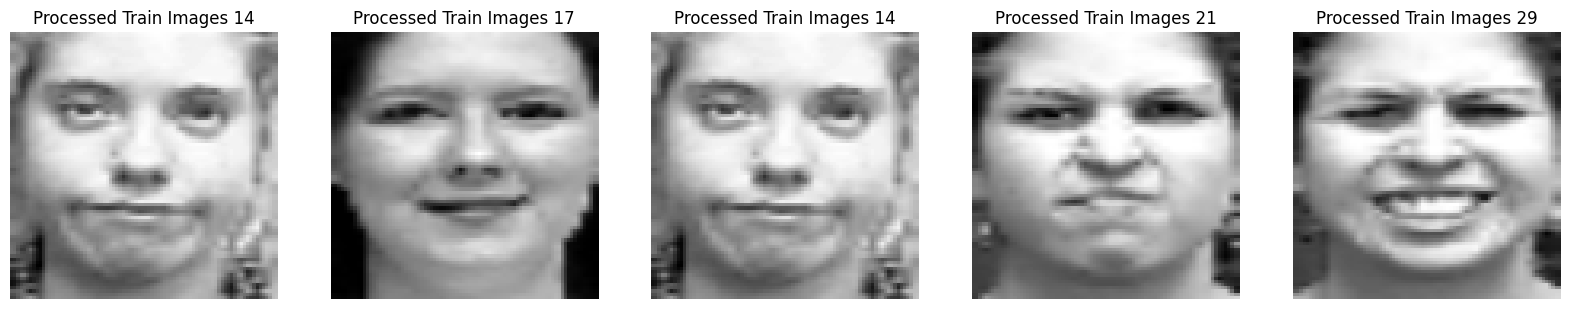

In [21]:
# Train
display_random_images(train_loader, "Processed Train Images")

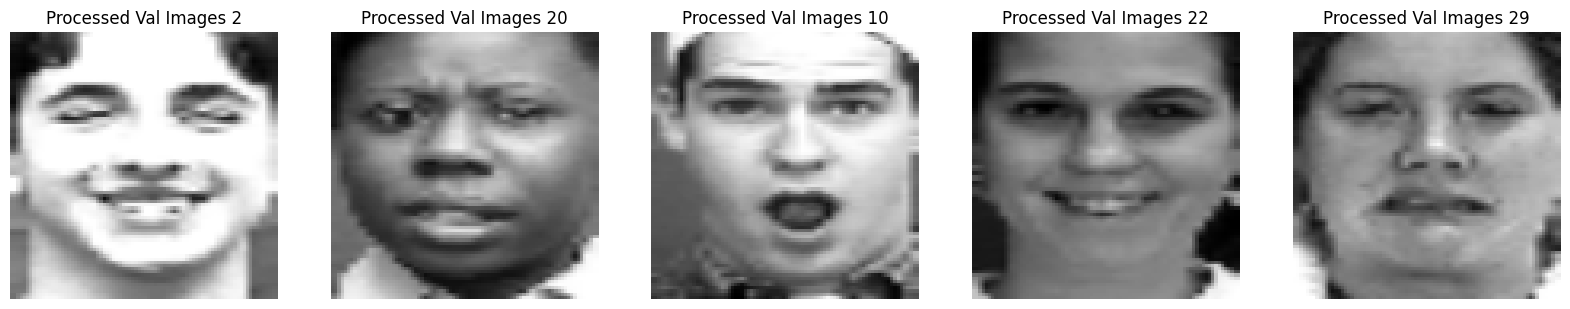

In [22]:
# Val
display_random_images(val_loader, "Processed Val Images")

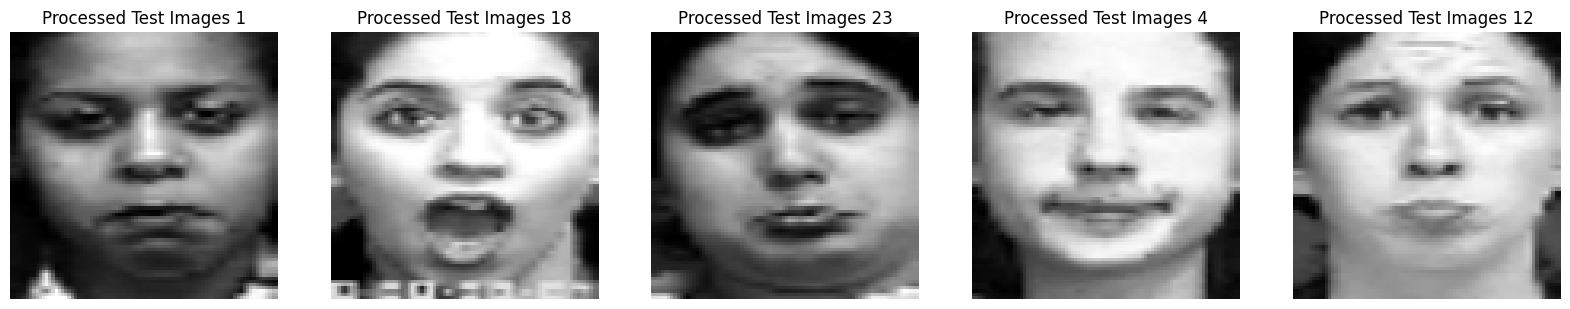

In [23]:
# Test
display_random_images(test_loader, "Processed Test Images")

## [4] MODEL TRAINING

4.1 Build Model

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam

In [25]:
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define the input layer
input_layer = Input(shape=(84, 84, 1))

# Define the shared CNN layers
x = Conv2D(512, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(256, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


# Define the emotion output branch
emotion_output = Dense(3, activation='softmax', name='emotion_output')(x)

# Define the FACS output branch
# In this branch, we start from the same shared layers (x)
facs_branch = Dense(256, activation='elu', kernel_initializer='he_normal')(x)
facs_branch = BatchNormalization()(facs_branch)
facs_branch = Dropout(0.25)(facs_branch)
au_outputs = [Dense(1, activation='sigmoid', name=f'AU{au_code}_output')(facs_branch) for au_code in au_codes]

# Create the model with inputs from the input layer and outputs from both branches
model = Model(inputs=input_layer, outputs=[emotion_output] + au_outputs)

# Compile the model with appropriate loss functions for each output and the optimizer
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss={'emotion_output': 'categorical_crossentropy', **{f'AU{au_code}_output': 'binary_crossentropy' for au_code in au_codes}},
              loss_weights={'emotion_output': 1.0, **{f'AU{au_code}_output': 0.001 for au_code in au_codes}},
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 84, 84, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 84, 84, 512)          13312     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 84, 84, 512)          2048      ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 84, 84, 256)          3277056   ['batch_normalization[0][0

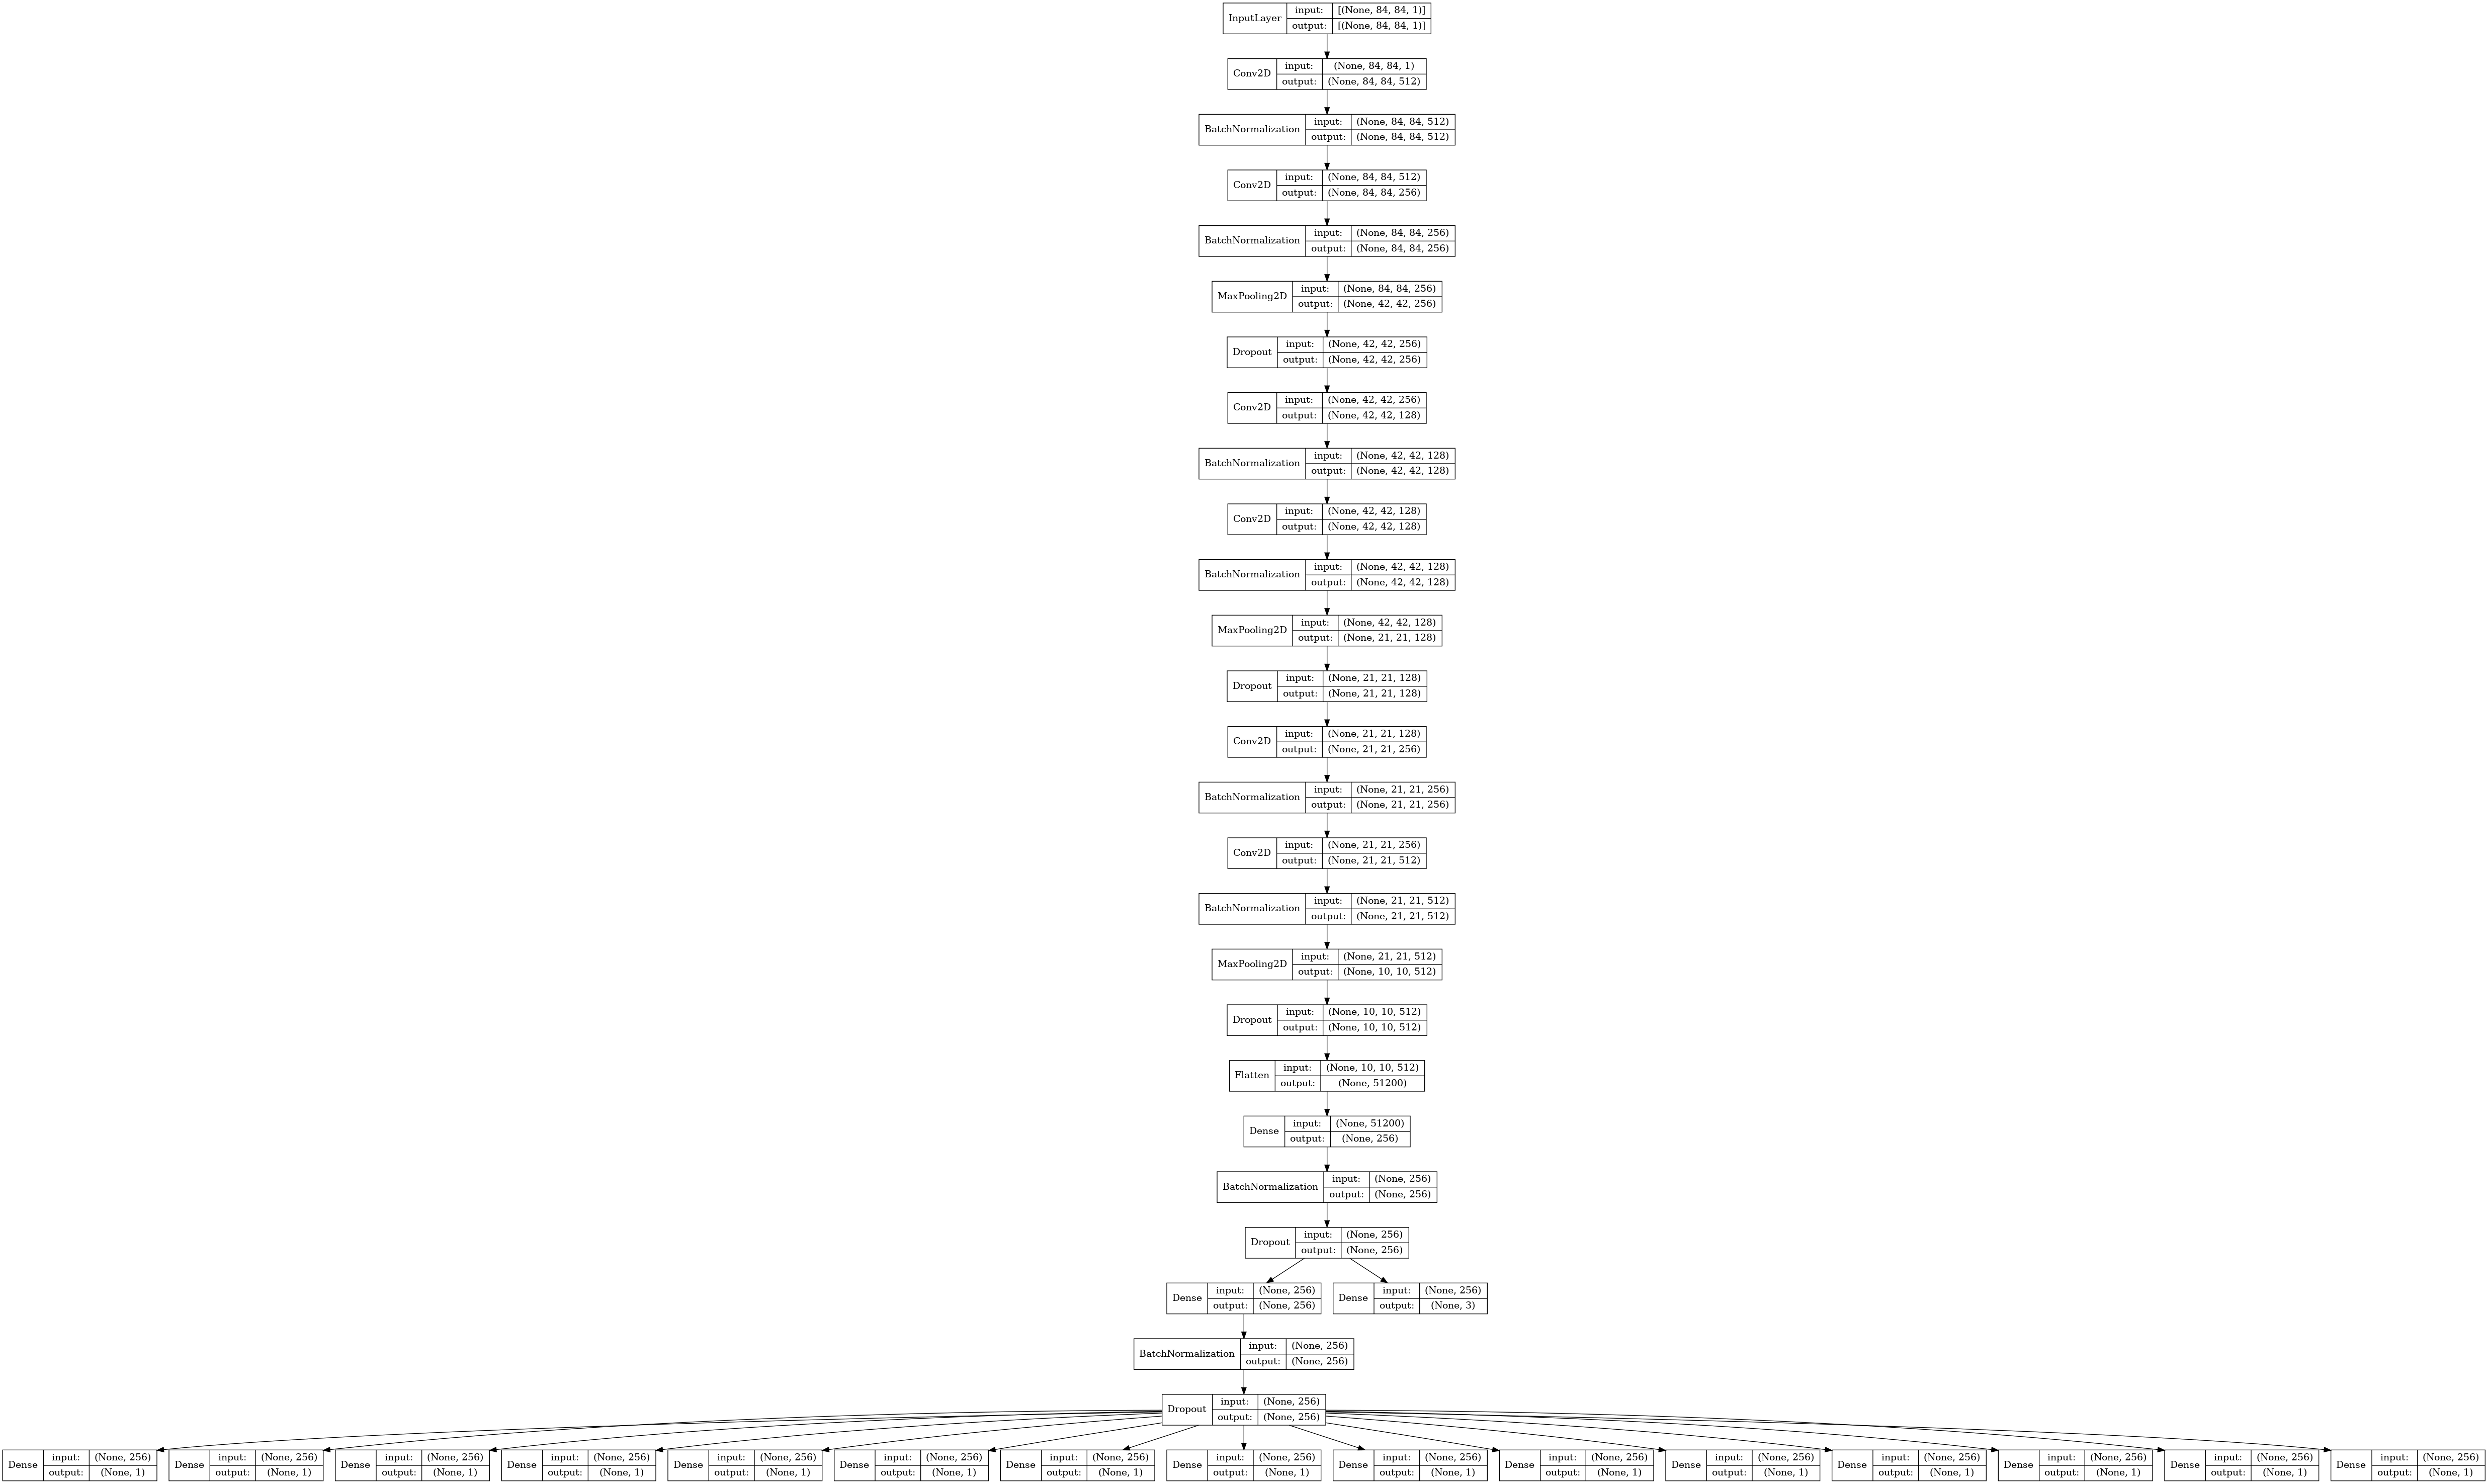

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=False, show_shapes=True, to_file='model.png')

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

# Define the ModelCheckpoint callback
checkpoint_path = "best_model.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,    # Only save a model if 'val_loss' has improved
    monitor='val_loss',     # Monitor 'val_loss' during training
    mode='min',             # The model is saved when 'val_loss' is minimized
    verbose=1)

# Combine all callbacks in a list
callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint_callback
]

In [28]:
# Change in training configuration
epochs = 100
batch_size = 64

# Define the checkpoint path and filename
checkpoint_path = "best_model.h5"


history = model.fit(train_loader, 
                    validation_data=val_loader, 
                    epochs=epochs,
                    callbacks = [model_checkpoint_callback])

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.3106 - emotion_output_loss: 1.2969 - AU17_output_loss: 0.8595 - AU1_output_loss: 0.8356 - AU2_output_loss: 0.9025 - AU25_output_loss: 0.9302 - AU27_output_loss: 0.9246 - AU4_output_loss: 0.9623 - AU7_output_loss: 0.9289 - AU23_output_loss: 0.9771 - AU24_output_loss: 0.9157 - AU6_output_loss: 0.8789 - AU12_output_loss: 0.9483 - AU15_output_loss: 0.9693 - AU14_output_loss: 0.8993 - AU11_output_loss: 0.9374 - AU26_output_loss: 0.8625 - emotion_output_accuracy: 0.6339 - AU17_output_accuracy: 0.4955 - AU1_output_accuracy: 0.5246 - AU2_output_accuracy: 0.5134 - AU25_output_accuracy: 0.4933 - AU27_output_accuracy: 0.5022 - AU4_output_accuracy: 0.5246 - AU7_output_accuracy: 0.5268 - AU23_output_accuracy: 0.5402 - AU24_output_accuracy: 0.4933 - AU6_output_accuracy: 0.4866 - AU12_output_accuracy: 0.4710 - AU15_output_accuracy: 0.4799 - AU14_output_accuracy: 0.5134 - AU11_output_accuracy: 0.5045 - AU26_output_accuracy: 0.5536 

/home/baos/anaconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 195s 14s/step - loss: 1.3106 - emotion_output_loss: 1.2969 - AU17_output_loss: 0.8595 - AU1_output_loss: 0.8356 - AU2_output_loss: 0.9025 - AU25_output_loss: 0.9302 - AU27_output_loss: 0.9246 - AU4_output_loss: 0.9623 - AU7_output_loss: 0.9289 - AU23_output_loss: 0.9771 - AU24_output_loss: 0.9157 - AU6_output_loss: 0.8789 - AU12_output_loss: 0.9483 - AU15_output_loss: 0.9693 - AU14_output_loss: 0.8993 - AU11_output_loss: 0.9374 - AU26_output_loss: 0.8625 - emotion_output_accuracy: 0.6339 - AU17_output_accuracy: 0.4955 - AU1_output_accuracy: 0.5246 - AU2_output_accuracy: 0.5134 - AU25_output_accuracy: 0.4933 - AU27_output_accuracy: 0.5022 - AU4_output_accuracy: 0.5246 - AU7_output_accuracy: 0.5268 - AU23_output_accuracy: 0.5402 - AU24_output_accuracy: 0.4933 - AU6_output_accuracy: 0.4866 - AU12_output_accuracy: 0.4710 - AU15_output_accuracy: 0.4799 - AU14_output_accuracy: 0.5134 - AU11_output_accuracy: 0.5045 - AU26_output_accuracy: 0.5536 - val_

4.2 Plot losses

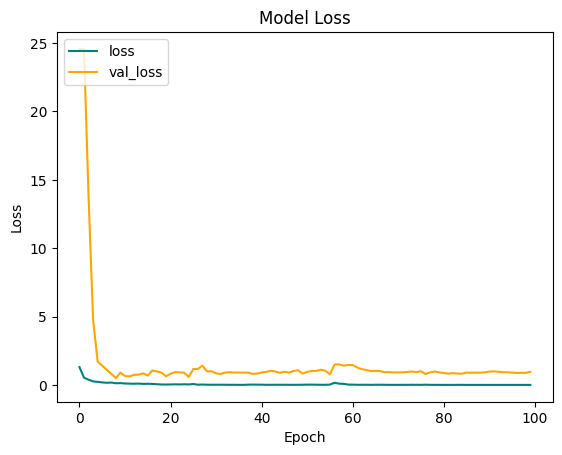

In [29]:
fig = plt.Figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('losses', fontsize = 20)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper left')
plt.show()

4.3 Plot Emotion Output Accuracies

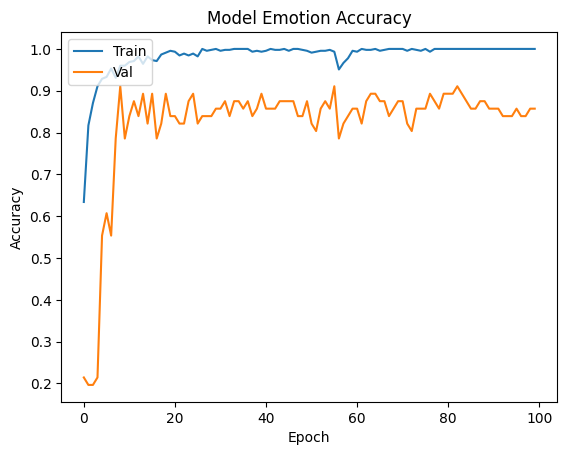

In [30]:
plt.plot(history.history['emotion_output_accuracy'])
plt.plot(history.history['val_emotion_output_accuracy'])
plt.title('Model Emotion Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## [5] EVALUATE BEST MODEL PERFORMANCE

In [31]:
from tensorflow.keras.models import load_model

In [32]:
def generate_predictions(model, data_loader):
    emotion_predictions = []
    emotion_true = []
    facs_predictions = {au_code: [] for au_code in au_codes}
    facs_true = {au_code: [] for au_code in au_codes}

    for X, y in data_loader:
        preds = model.predict(X)
        emotion_predictions.extend(preds[0])
        emotion_true.extend(y['emotion_output'])

        # Assuming each model predicts only one FACS code
        facs_pred = preds[1].flatten()  # Flattening since it's a single value
        for au_code in au_codes:
            facs_predictions[au_code].extend(facs_pred)
            facs_true[au_code].extend(y[f'{au_code}_output'])

    return (np.array(emotion_predictions), np.array(emotion_true)), \
           {au_code: np.array(facs_predictions[au_code]) for au_code in au_codes}, \
           {au_code: np.array(facs_true[au_code]) for au_code in au_codes}

In [33]:
# Load the best model
model = load_model('best_model.h5')

# Evaluate the model on the test set
evaluation = model.evaluate(test_loader)

# Unpacking the evaluation results
total_loss = evaluation[0] # Total loss
loss_facs = evaluation[1] # Loss for FACS output
loss_emotion = evaluation[2] # Loss for emotion output
accuracy_facs = evaluation[3] # Accuracy for FACS output
accuracy_emotion = evaluation[4] # Accuracy for emotion output

2/2 [==============================] - 7s 3s/step - loss: 0.2914 - emotion_output_loss: 0.2816 - AU17_output_loss: 0.7288 - AU1_output_loss: 0.7859 - AU2_output_loss: 0.6298 - AU25_output_loss: 0.7514 - AU27_output_loss: 0.5721 - AU4_output_loss: 0.6477 - AU7_output_loss: 0.6678 - AU23_output_loss: 0.4642 - AU24_output_loss: 0.7567 - AU6_output_loss: 0.5917 - AU12_output_loss: 0.8152 - AU15_output_loss: 0.6080 - AU14_output_loss: 0.7361 - AU11_output_loss: 0.3650 - AU26_output_loss: 0.7033 - emotion_output_accuracy: 0.9286 - AU17_output_accuracy: 0.5536 - AU1_output_accuracy: 0.4464 - AU2_output_accuracy: 0.7143 - AU25_output_accuracy: 0.4643 - AU27_output_accuracy: 0.7143 - AU4_output_accuracy: 0.6786 - AU7_output_accuracy: 0.5893 - AU23_output_accuracy: 0.8214 - AU24_output_accuracy: 0.3929 - AU6_output_accuracy: 0.6964 - AU12_output_accuracy: 0.3750 - AU15_output_accuracy: 0.7321 - AU14_output_accuracy: 0.5714 - AU11_output_accuracy: 0.8929 - AU26_output_accuracy: 0.4286


In [34]:
predictions = model.predict(test_loader)

2/2 [==============================] - 7s 3s/step


In [35]:
facs_predictions, emotion_predictions = predictions[0:15],predictions[15]

In [36]:
# Processing FACS predictions: Convert probabilities to binary values to string
au_codes = ["AU17", "AU1", "AU2", "AU25", "AU27", "AU4", "AU7", "AU23", "AU24", "AU6", "AU12", "AU15", "AU14", "AU11", "AU26"]
facs_pred_binary = []
for i in facs_predictions:
    facs_pred_binary.append((i > 0.5).astype(int))

grouped_facs = []
for i in range(len(emotion_predictions)):
    group = [facs_pred_binary[j][i][0] for j in range(15)]
    grouped_facs.append(group)

pred_facs = []
for item in grouped_facs:
    selected_codes = [code for code, value in zip(au_codes, item) if value == 1]
    pred_facs.append(selected_codes)

In [37]:
# Processing Emotion predictions: Convert probabilities to class labels
emotion_pred_labels = np.argmax(emotion_predictions, axis=1)
names = ['negative','positive','surprise']
def getLabel(id):
    return ['negative','positive','surprise'][id]

pred_emotions = []
for emotion in emotion_pred_labels:
    pred_emotions.append(getLabel(emotion))

1/1 [==============================] - 3s 3s/step


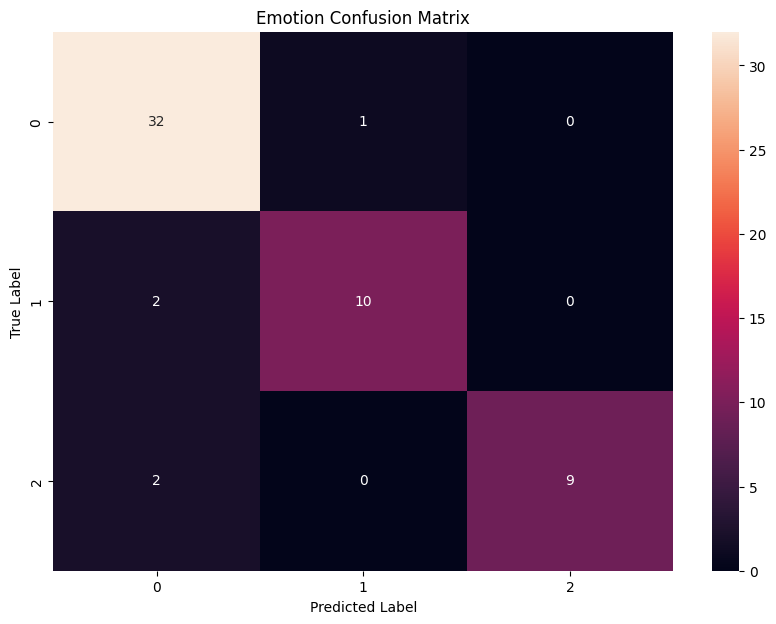

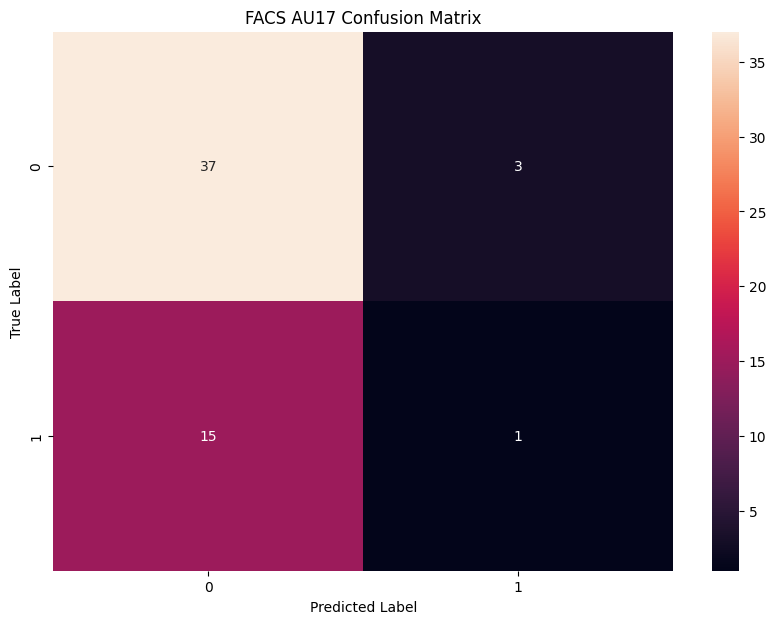

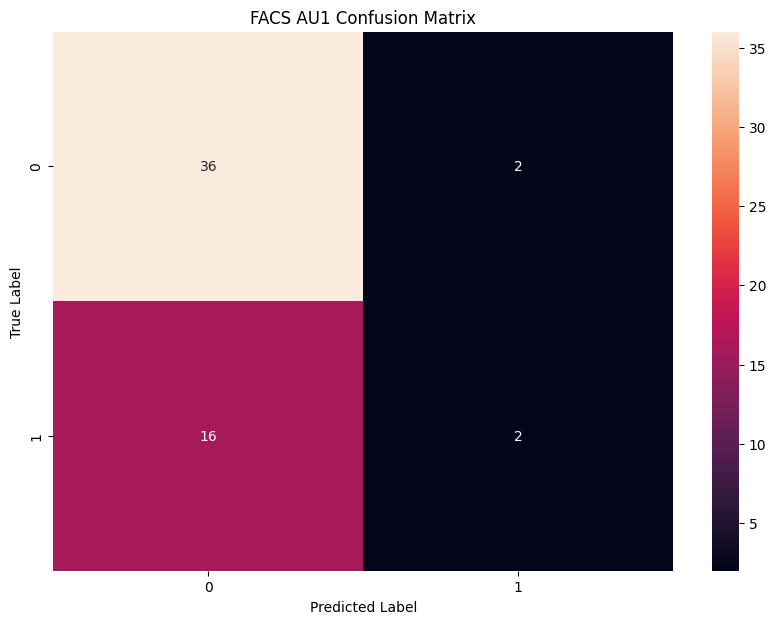

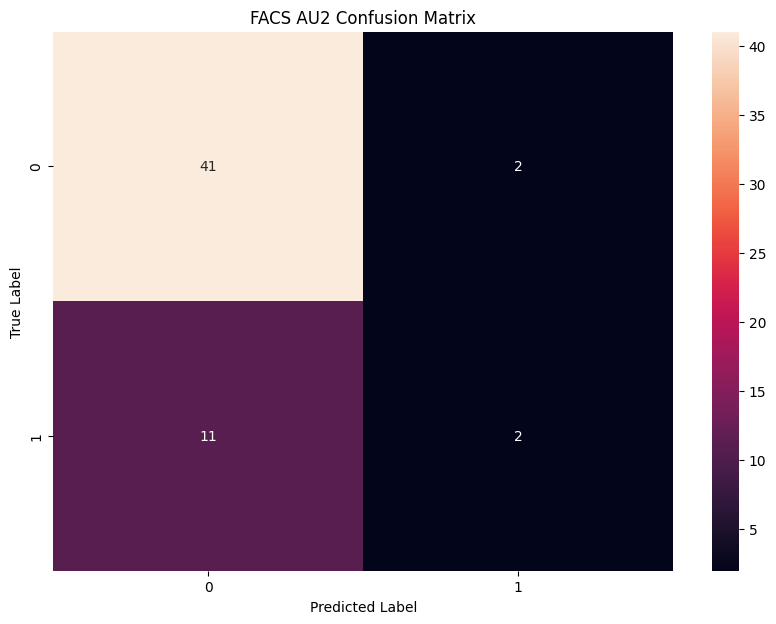

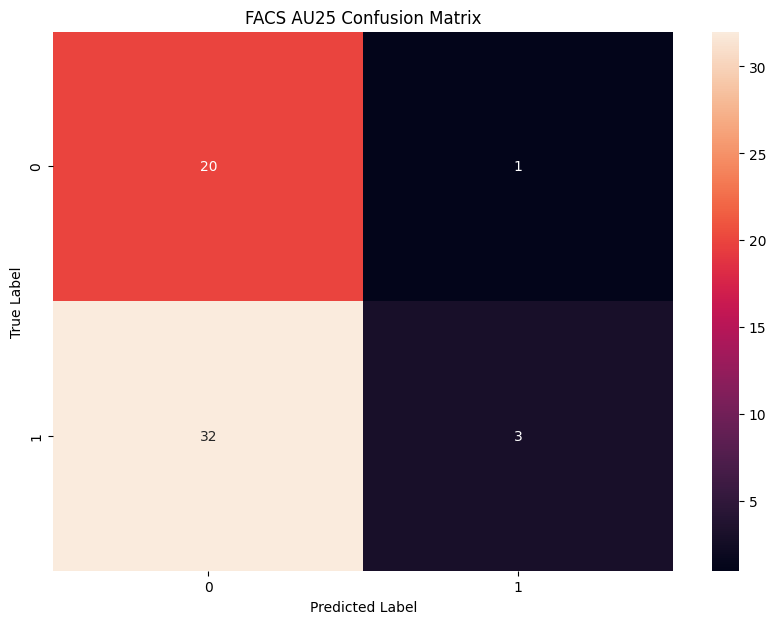

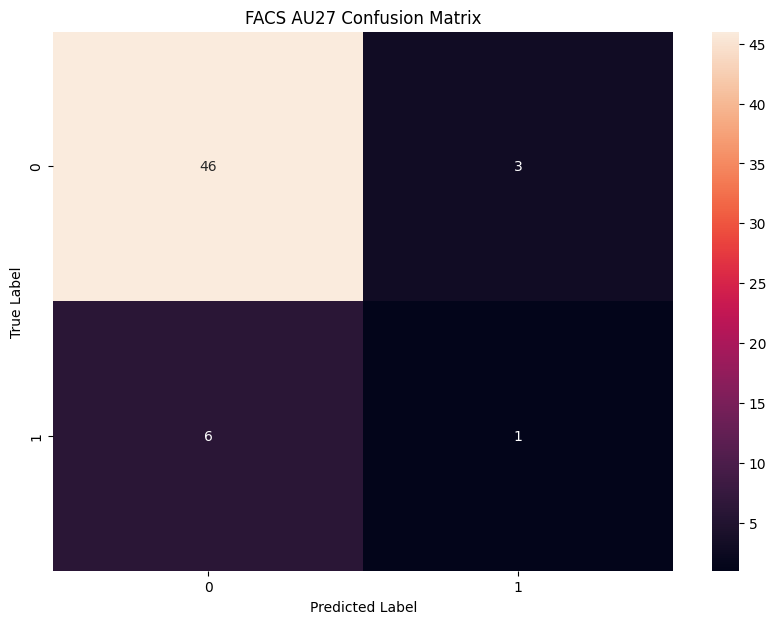

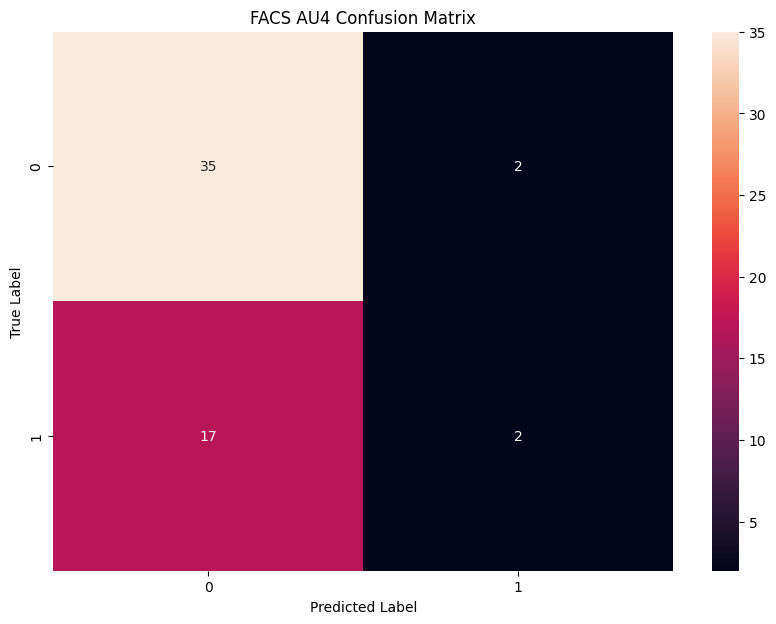

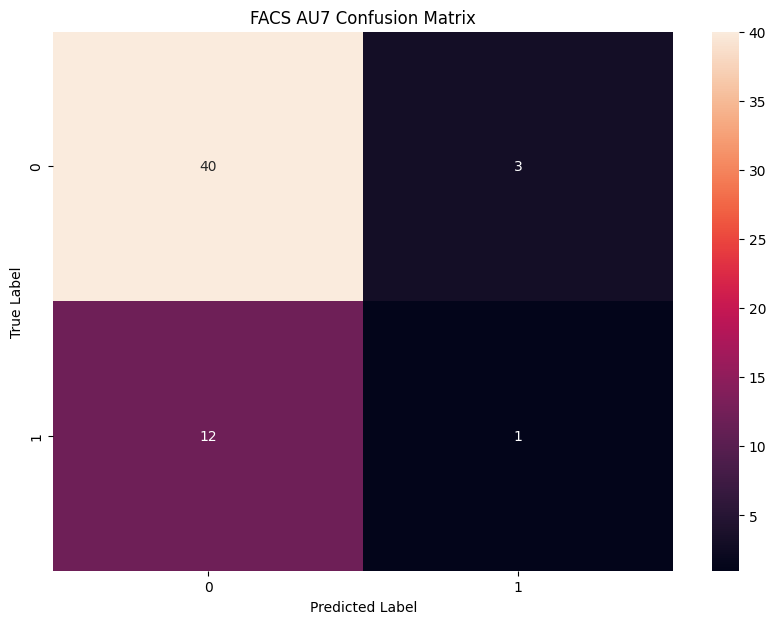

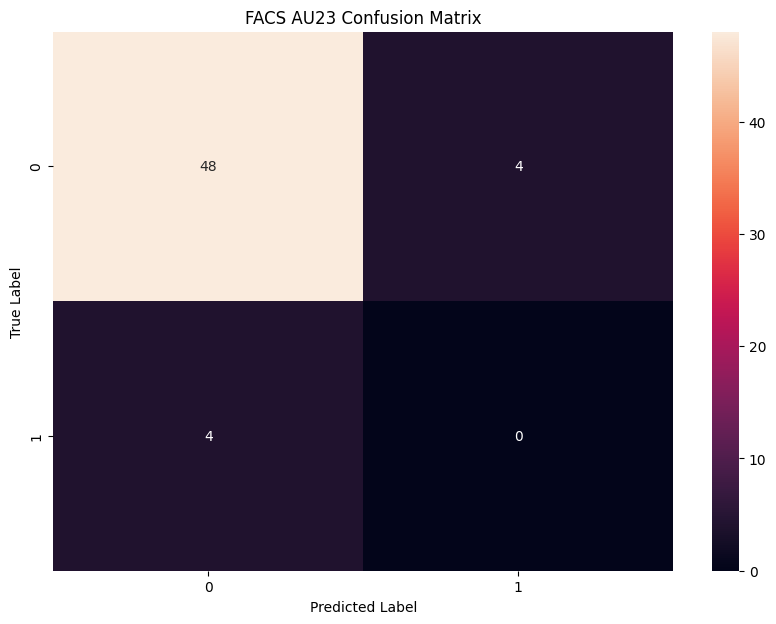

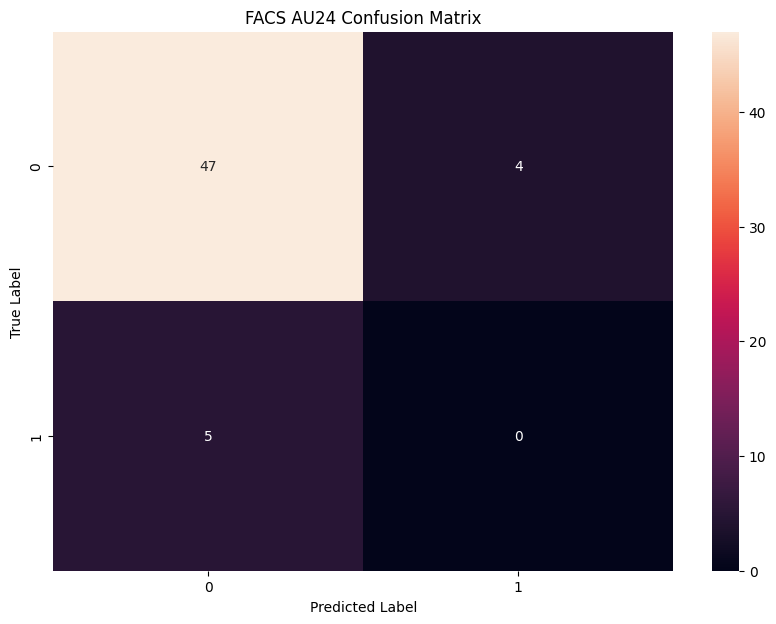

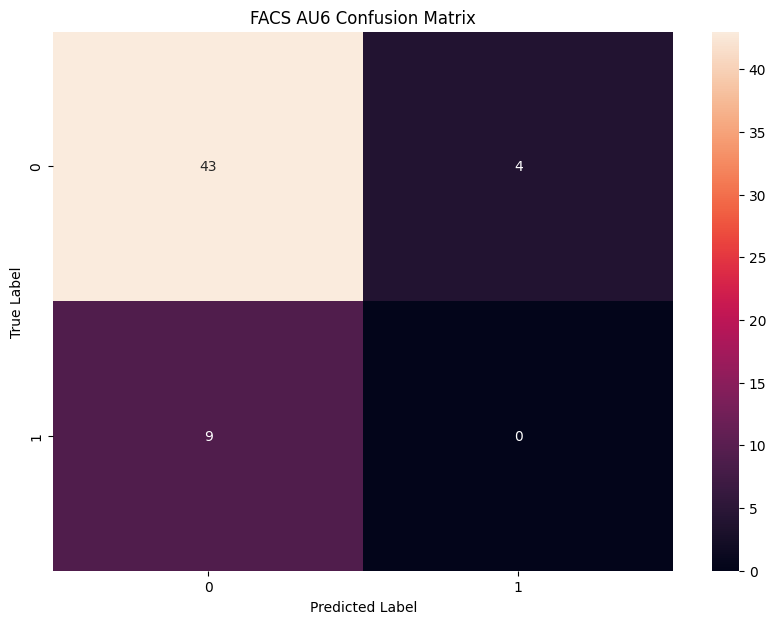

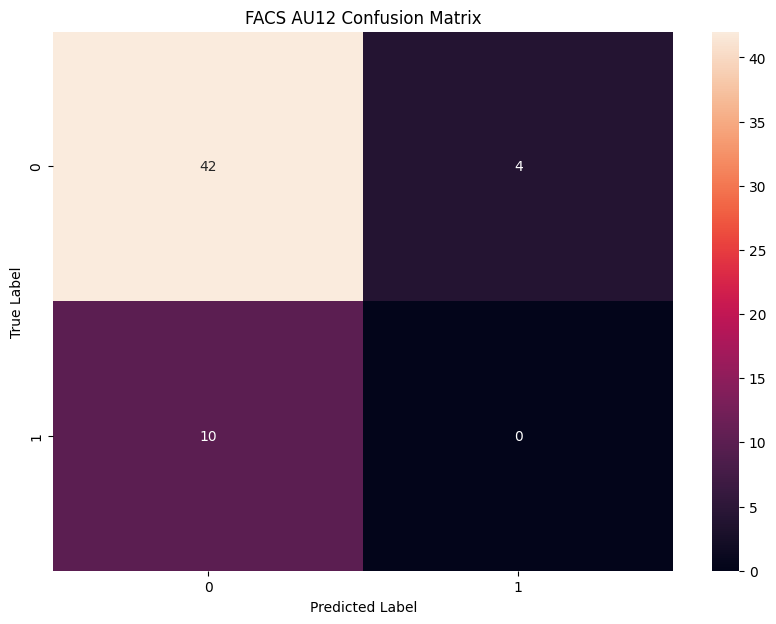

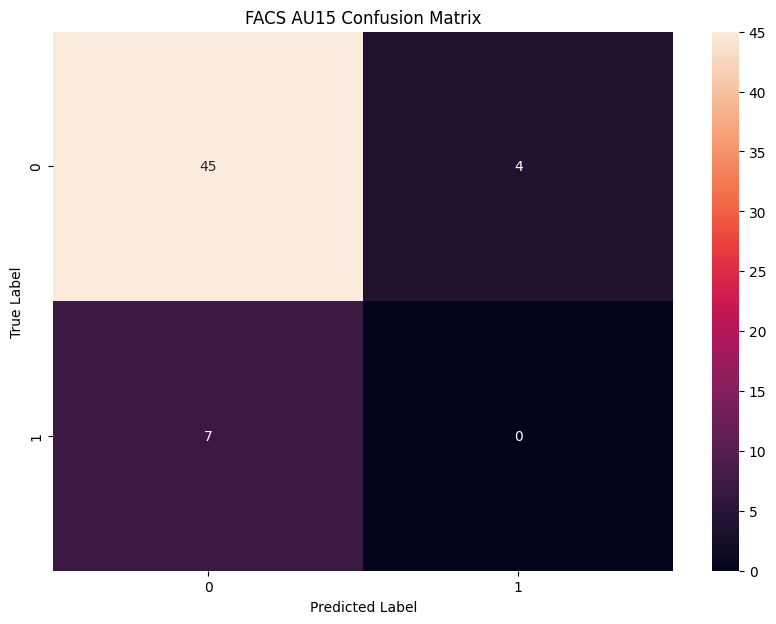

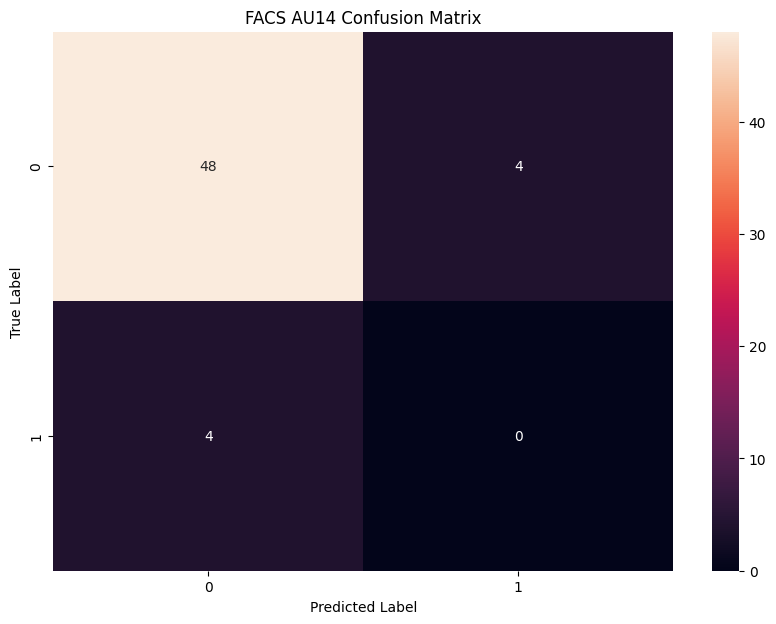

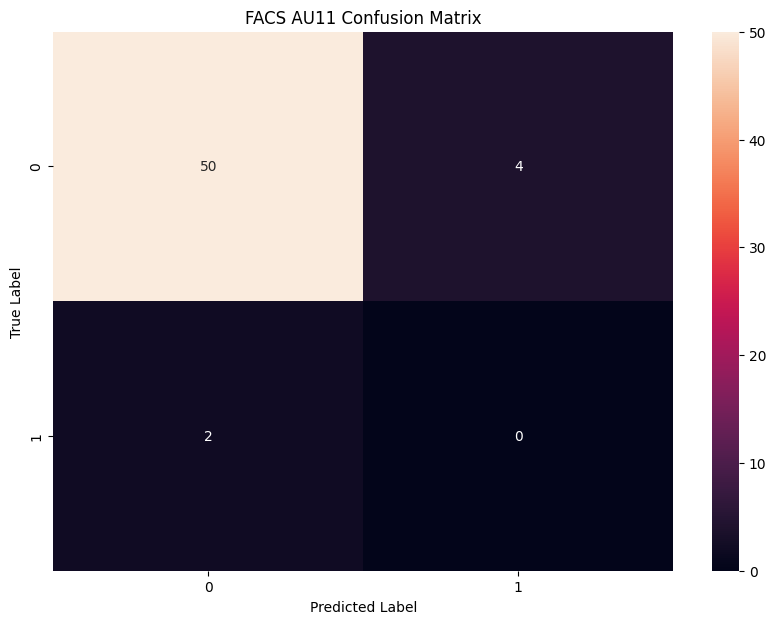

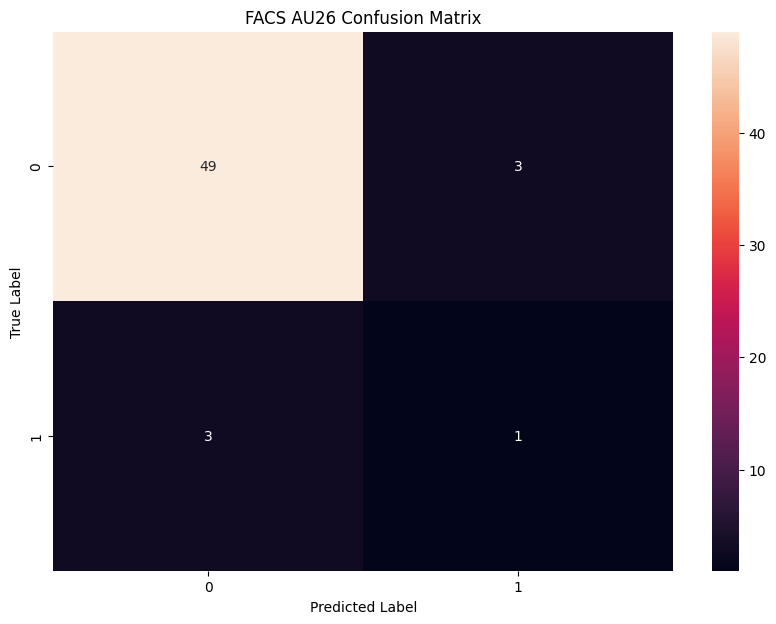

In [38]:
from sklearn.metrics import confusion_matrix

# Generate predictions
(emotion_preds, emotion_true), facs_preds_dict, facs_true_dict = generate_predictions(model, val_loader)


emotion_cm = confusion_matrix(emotion_true.argmax(axis=1), emotion_preds.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(emotion_cm, annot=True, fmt='d')
plt.title('Emotion Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

for au_code in au_codes:
    facs_pred_labels = facs_preds_dict[au_code] > 0.5
    facs_true_labels = facs_true_dict[au_code]
    facs_cm = confusion_matrix(facs_true_labels, facs_pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(facs_cm, annot=True, fmt='d')
    plt.title(f'FACS {au_code} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [39]:
from sklearn.metrics import classification_report

In [40]:
emotion_report = classification_report(emotion_true.argmax(axis=1), emotion_preds.argmax(axis=1), target_names=['negative', 'positive', 'surprise'])
print("Emotion Classification Report:\n", emotion_report)

Emotion Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.97      0.93        33
    positive       0.91      0.83      0.87        12
    surprise       1.00      0.82      0.90        11

    accuracy                           0.91        56
   macro avg       0.93      0.87      0.90        56
weighted avg       0.92      0.91      0.91        56



In [41]:
for au_code in au_codes:
    facs_pred_labels = facs_preds_dict[au_code] > 0.5
    facs_true_labels = facs_true_dict[au_code]
    facs_report = classification_report(facs_true_labels, facs_pred_labels)
    print(f"FACS {au_code} Classification Report:\n", facs_report)


FACS AU17 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.93      0.80        40
           1       0.25      0.06      0.10        16

    accuracy                           0.68        56
   macro avg       0.48      0.49      0.45        56
weighted avg       0.58      0.68      0.60        56

FACS AU1 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80        38
           1       0.50      0.11      0.18        18

    accuracy                           0.68        56
   macro avg       0.60      0.53      0.49        56
weighted avg       0.63      0.68      0.60        56

FACS AU2 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86        43
           1       0.50      0.15      0.24        13

    accuracy                           0.77        56
   macro avg       0.64     

In [42]:
pred_facs

[['AU17', 'AU2', 'AU27', 'AU6', 'AU15', 'AU11'],
 ['AU17', 'AU6', 'AU11'],
 ['AU17', 'AU2', 'AU27', 'AU6', 'AU15', 'AU11'],
 ['AU17', 'AU2', 'AU27', 'AU6', 'AU12', 'AU15', 'AU11'],
 ['AU17', 'AU27', 'AU23', 'AU6', 'AU12', 'AU15'],
 ['AU2', 'AU23', 'AU15', 'AU11', 'AU26'],
 ['AU2', 'AU15', 'AU14'],
 ['AU17', 'AU2', 'AU27', 'AU6', 'AU15'],
 ['AU2', 'AU6', 'AU15'],
 ['AU2', 'AU15', 'AU14'],
 ['AU17', 'AU6', 'AU15'],
 ['AU17', 'AU2', 'AU27', 'AU23', 'AU6', 'AU11'],
 ['AU17', 'AU2', 'AU27', 'AU23', 'AU6', 'AU15', 'AU11'],
 ['AU17', 'AU27', 'AU23', 'AU6'],
 ['AU2', 'AU25', 'AU15'],
 ['AU2', 'AU15'],
 ['AU17', 'AU2', 'AU27', 'AU6', 'AU15', 'AU11'],
 ['AU17', 'AU2', 'AU27', 'AU6', 'AU12', 'AU15', 'AU11'],
 ['AU2', 'AU6', 'AU12', 'AU15', 'AU11'],
 ['AU6', 'AU15', 'AU11', 'AU26'],
 ['AU17', 'AU2', 'AU27', 'AU6', 'AU15'],
 ['AU17', 'AU2', 'AU4'],
 ['AU17', 'AU27', 'AU23', 'AU6'],
 ['AU17', 'AU2', 'AU25', 'AU27', 'AU4', 'AU6'],
 ['AU17', 'AU27', 'AU6', 'AU12', 'AU15'],
 ['AU17', 'AU27', 'AU23', 'A

In [43]:
pred_emotions

['negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative']